# Проект: Анализ A/B теста по изменению выкладки товара

## Цель проекта
Оценить влияние изменения расположения товарной полки в магазине на продажи.  
Компания планирует переместить популярную категорию товаров ближе к основному потоку покупателей, чтобы увеличить продажи.

---

## Гипотезы

- **Нулевая гипотеза (H₀):** Перемещение полки не влияет на продажи.
- **Альтернативная гипотеза (H₁):** Перемещение полки увеличивает продажи.

---

## Описание данных

Для имитации реального теста были сгенерированы синтетические данные.  
Они моделируют поведение продаж в контрольной и тестовой группах магазинов.  
Контрольная группа продолжала использовать старое расположение полки, тестовая группа использовала новое размещение.

---

## Структура проекта

1. Исследование данных и визуализация
2. Проверка нормальности распределений
3. Выбор и проведение статистического теста
4. Расчёт бизнес-эффекта (Lift)
5. Визуализация прироста продаж
6. Рекомендации для бизнеса и финальные выводы
---
## Импортируем все необходимые для работы библиотеки и определяем вспомогательные функции:

In [2]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import warnings

# Отключение предупреждений
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# Функция для проверки нормальности распределения (с выводом в таблицу)

def check_normality_table(group1, group2, name1='Группа 1', name2='Группа 2'):
    """
    Проверяет нормальность распределения двух групп с помощью теста Шапиро-Уилка.

    Параметры:
    - group1, group2: данные для проверки
    - name1, name2: названия групп для красивого вывода
    """
    results = []

    for data, name in zip([group1, group2], [name1, name2]):
        stat, p_value = shapiro(data)
        normal = 'Да' if p_value > 0.05 else 'Нет'
        results.append({'Группа': name, 'p-value': p_value, 'Нормальное распределение?': normal})

    return pd.DataFrame(results)

# -----------------------------------------------------------------------------
# Функция для проведения универсального A/B теста с выбором теста автоматически

def run_ab_test(group1, group2, alpha=0.05):
    """
    Проводит A/B тест:
    - Если обе группы нормальны — t-тест (Welch)
    - Иначе — тест Манна-Уитни.

    Параметры:
    - group1, group2: массивы данных
    - alpha: уровень значимости
    """
    print("Проводим A/B-тест...")

    # Проверка нормальности
    p1 = shapiro(group1).pvalue
    p2 = shapiro(group2).pvalue

    if (p1 > alpha) and (p2 > alpha):
        # Нормальные распределения — t-тест
        stat, p_value = ttest_ind(group1, group2, equal_var=False)
        test_name = 't-тест (Welch)'
    else:
        # Иначе — тест Манна-Уитни
        stat, p_value = mannwhitneyu(group1, group2)
        test_name = 'Тест Манна-Уитни'

    print(f"Выбранный тест: {test_name}")
    print(f"Статистика теста = {stat:.3f}, p-value = {p_value:.5f}")

    if p_value < alpha:
        print("Различия статистически значимы (отвергаем H₀).\n")
    else:
        print("Различия статистически незначимы (не отвергаем H₀).\n")

# -----------------------------------------------------------------------------
# Функция для проведения одностороннего t-теста (на увеличение) с правильным порядком

def run_ab_test_table(group_test, group_control, alpha=0.05):
    """
    Проводит односторонний t-тест на увеличение.

    Параметры:
    - group_test: тестовая группа
    - group_control: контрольная группа
    - alpha: уровень значимости
    """
    t_stat, p_value = ttest_ind(group_test, group_control, alternative='greater')

    result_table = pd.DataFrame({
        'Тест': ['Односторонний t-тест (на увеличение)'],
        'T-статистика': [t_stat],
        'p-value': [p_value],
        'Статистически значимо (p < 0.05)': ['Да' if p_value < alpha else 'Нет']
    })

    return result_table


## Генерация синтетических данных

Для целей данного проекта создадим искусственные данные, моделирующие результаты A/B теста:

- **Контрольная группа:** продажи в магазине до изменения расположения полки (среднее = 500 000₽).
- **Тестовая группа:** продажи после изменения расположения полки (среднее = 515 000₽, предполагаемый прирост на 3%).

Данные генерируются из нормального распределения с одинаковой дисперсией в обеих группах.

Это позволит смоделировать реальную задачу проверки эффективности изменений в магазине.


In [4]:
# Генерируем синтетические данные для имитации A/B теста

np.random.seed(42)  # Фиксируем random seed для воспроизводимости результатов

# Задаём размеры групп
n_control = 250
n_test = 250

# Продажи в контрольной группе (старое расположение полки, среднее 500 000₽)
control_sales = np.random.normal(loc=500000, scale=50000, size=n_control)

# Продажи в тестовой группе (новое расположение полки, среднее 515 000₽, эффект +3%)
test_sales = np.random.normal(loc=515000, scale=50000, size=n_test)

# Создание общего DataFrame
df_ab = pd.DataFrame({
    "store_id": np.arange(1, n_control + n_test + 1),
    "group": ["control"] * n_control + ["test"] * n_test,
    "sales": np.concatenate([control_sales, test_sales])
})

# Просмотр первых строк
df_ab.head()

,store_id,group,sales
0,1,control,524835.707651
1,2,control,493086.784941
2,3,control,532384.426905
3,4,control,576151.492820
4,5,control,488292.331264


## 1. Исследование данных и визуализация

Теперь давайте посмотрим на основные статистические характеристики наших данных и визуализируем распределения в контрольной и тестовой группах.

Сначала изучим описательные статистики, чтобы понять средние продажи и разброс значений в каждой группе. Затем построим гистограммы и Q-Q графики, чтобы оценить форму распределений.

---
### 1.1 Базовый анализ продаж по группам

Посмотрим основные статистики (`mean`, `std`, `min`, `max`) для контрольной и тестовой групп, чтобы понять общую картину:

- Средние продажи.
- Дисперсию значений.
- Наличие явных выбросов.

In [6]:
# Посмотрим статистические данные по группам
df_ab.groupby('group')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,250.0,499878.854794,48302.684792,369012.744796,466037.547937,502960.97321,529143.272401,692636.574533
test,250.0,515804.944665,49903.677461,352936.632997,479715.826189,514931.77646,548944.143284,668944.040423


### 1.2 Визуализация распределений продаж

Построим гистограммы для контрольной и тестовой групп:

- Оценим форму распределений.
- Проверим наличие сдвигов и выбросов.


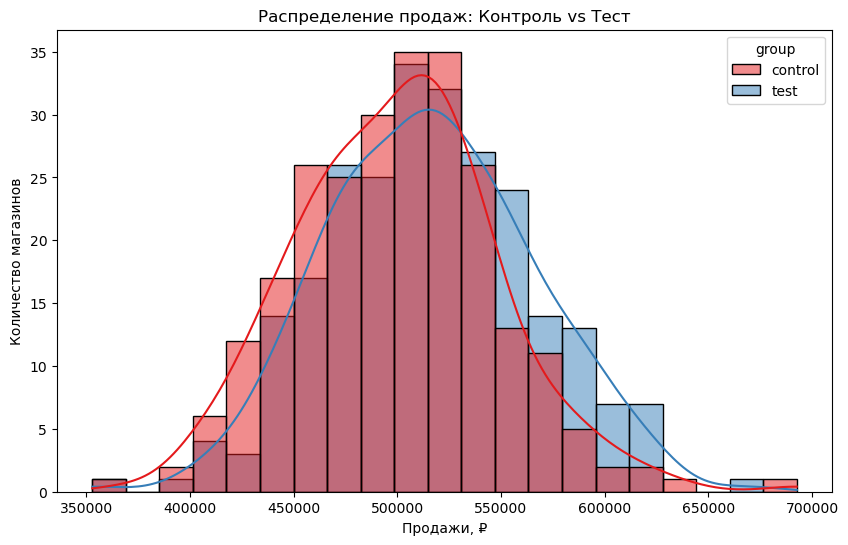

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ab, x='sales', hue='group', kde=True, palette="Set1")
plt.title('Распределение продаж: Контроль vs Тест')
plt.xlabel('Продажи, ₽')
plt.ylabel('Количество магазинов')
plt.show()

На графике мы видим, что распределения продаж в контрольной и тестовой группах имеют близкую к нормальной форму.

Тестовая группа немного смещена вправо по сравнению с контрольной, что может свидетельствовать о небольшом увеличении продаж при новом расположении полки.

Разброс значений (ширина распределений) в обеих группах сопоставим, что является хорошим признаком для дальнейшего статистического анализа.

На этом этапе можно предположить, что распределения нормальные. Чтобы подтвердить это, дополнительно построим Q-Q диаграммы и при необходимости проведем тест Шапиро-Уилка.

---

## 2. Проверка нормальности распределений

Q-Q графики позволяют визуально оценить, насколько распределения контрольной и тестовой групп близки к нормальному.

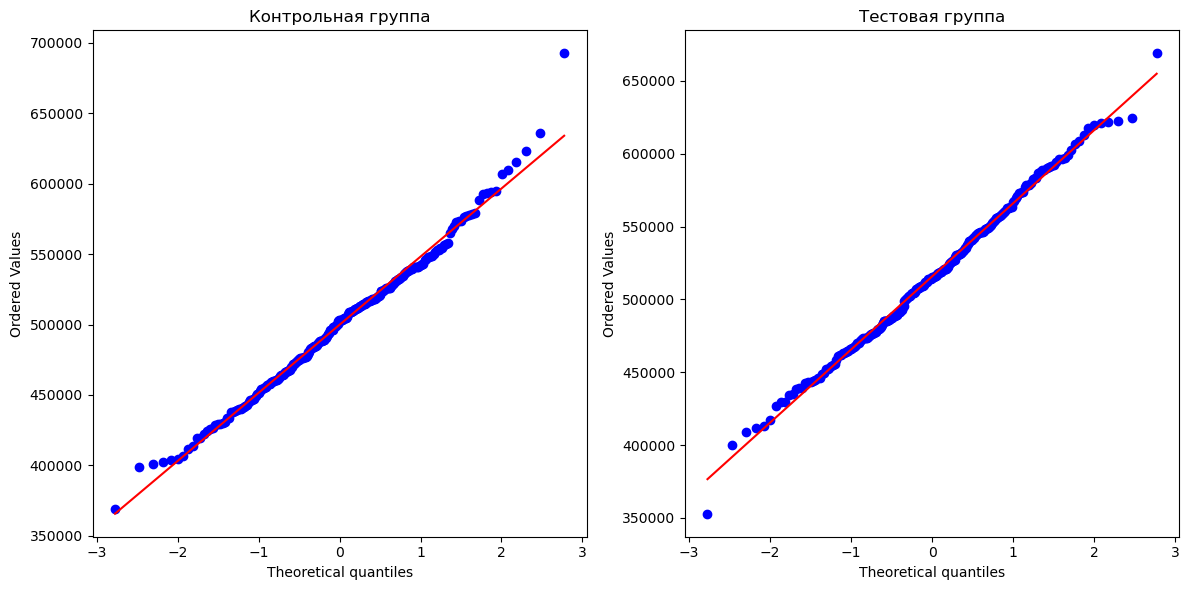

In [10]:
control_sales = df_ab[df_ab['group'] == 'control']['sales']
test_sales = df_ab[df_ab['group'] == 'test']['sales']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

stats.probplot(control_sales, dist="norm", plot=axes[0])
axes[0].set_title("Контрольная группа")

stats.probplot(test_sales, dist="norm", plot=axes[1])
axes[1].set_title("Тестовая группа")

plt.tight_layout()
plt.show()

### Вывод:
Как мы видим, на графиках, точки лежат примерно в доль линии, соответственно распределение нормальное, но для надежности я все же проведу тест Шапиро-Уилка.
Это важно для выбора корректного статистического теста:
- Если данные распределены нормально, мы применим параметрический t-тест.
- Если данные распределены ненормально, мы применим непараметрический тест Манна-Уитни.

In [12]:
# Проверка нормальности распределения
check_normality_table(control_sales, test_sales, name1='Контрольная', name2='Тестовая')

,Группа,p-value,Нормальное распределение?
0,Контрольная,0.125807,Да
1,Тестовая,0.883518,Да


### Вывод

Анализ описательных статистик и графиков показал, что распределения продаж в контрольной и тестовой группах имеют близкую к нормальной форме.

Гистограмма показала небольшое смещение тестовой группы вправо, что может свидетельствовать о росте продаж при новом расположении полки.

Распределения в обеих группах визуально соответствуют нормальному, что дополнительно подтвердилось с помощью Q-Q графиков.

Проведённый тест Шапиро-Уилка показал, что в обеих группах p-value значительно больше 0.05, следовательно, мы не отвергаем гипотезу о нормальности распределений.

Таким образом, для сравнения групп можно использовать параметрический t-test.

---

### 3. Выбор и проведение статистического теста

### Формулировка гипотез

- **Нулевая гипотеза (H₀):** Средние продажи в контрольной и тестовой группах равны.
- **Альтернативная гипотеза (H₁):** Средние продажи в тестовой группе выше, чем в контрольной.

Поскольку новая выкладка товара должна увеличить продажи, мы будем использовать односторонний t-test на увеличение.

In [14]:
# Проведение одностороннего t-test (проверка увеличения продаж)
run_ab_test_table(test_sales, control_sales)


,Тест,T-статистика,p-value,Статистически значимо (p < 0.05)
0,Односторонний t-тест (на увеличение),3.625741,0.000159,Да


### Вывод по результату t-test

- **p-value = 0.000159** (меньше 0.05), что позволяет нам отвергнуть нулевую гипотезу.
- Различия между контрольной и тестовой группами **статистически значимы**.

**Вывод:** новая выкладка товара **действительно увеличила продажи**.

На следующем этапе проверим размер эффекта и оценим его бизнес-значимость.

## 4. Расчёт бизнес-эффекта (Lift)

In [17]:
mean_control = control_sales.mean()
mean_test = test_sales.mean()

lift = (mean_test - mean_control) / mean_control * 100

print(f"Средние продажи (Контроль): {mean_control:.2f} ₽")
print(f"Средние продажи (Тест): {mean_test:.2f} ₽")
print(f"Прирост выручки = {lift:.2f}%")

Средние продажи (Контроль): 499878.85 ₽
Средние продажи (Тест): 515804.94 ₽
Прирост выручки = 3.19%


## 5. Визуализация прироста продаж

Для наглядности отобразим средние продажи в контрольной и тестовой группах с помощью столбчатой диаграммы.

Это позволит визуально оценить разницу в выручке между группами.


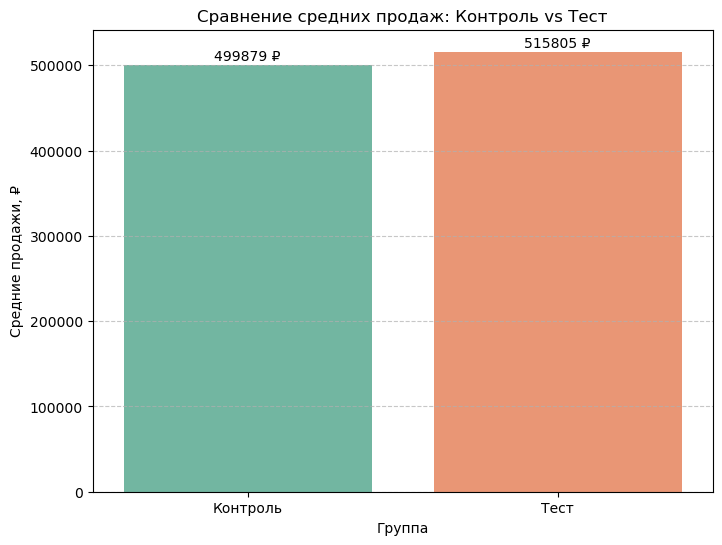

In [19]:
# Готовим данные
mean_sales = pd.DataFrame({
    "Группа": ["Контроль", "Тест"],
    "Средние продажи": [mean_control, mean_test]
})

# Построение графика
plt.figure(figsize=(8, 6))
sns.barplot(x="Группа", y="Средние продажи", data=mean_sales, palette="Set2")

plt.title("Сравнение средних продаж: Контроль vs Тест")
plt.ylabel("Средние продажи, ₽")
plt.xlabel("Группа")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отметим разницу на графике
for index, row in mean_sales.iterrows():
    plt.text(index, row["Средние продажи"] + 2000, f'{row["Средние продажи"]:.0f} ₽', ha='center', va='bottom')

plt.show()

## 6. Рекомендации для бизнеса и финальные выводы

### Вывод по бизнес-эффекту

Результаты расчёта бизнес-эффекта показали, что средние продажи в тестовой группе составили 515 804 ₽, в то время как в контрольной — 499 879 ₽.

Прирост выручки составил 3.19%, что подтверждает наличие не только статистически значимого, но и бизнес-значимого эффекта от изменения расположения полки.

Построенная диаграмма также наглядно демонстрирует увеличение продаж в тестовой группе по сравнению с контрольной.

---

### Итоги проекта

В рамках проекта был проведён A/B-тест для оценки влияния нового расположения полки на продажи.

Ключевые результаты:

- Распределения продаж в контрольной и тестовой группах являются нормальными, что позволило применить параметрический t-тест.
- Результаты теста показали статистически значимое увеличение продаж в тестовой группе по сравнению с контрольной (**p-value = 0.000159**).
- Расчёт бизнес-эффекта подтвердил прирост выручки на уровне **3.19%**, что указывает на бизнес-значимость изменений.

С учётом результатов можно рекомендовать внедрение нового расположения товара, при условии, что затраты на внедрение не превысят прирост выручки и не ухудшат коммерческую привлекательность.